<h2><center>Classifying Wildlife Images using the iNaturalist Dataset</center></h2>
<h3><center>Springboard | Capstone 2:   Data Wrangling and EDA </center></h3>
<h4><center>By: Lauren Broussard</center></h4>

In [1]:
#import necessary modules
import os
import cv2
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

%matplotlib inline

In [2]:
sns.set() # set graphs to follow seaborn default view

### DATA LOAD

First, we'll load the necessary packages, and import the iNaturalist annotations file so we can see more information about the labels and corresponding images.  

In [3]:
# import training annotations
ann_file = '../data/raw/train2019.json'

with open(ann_file) as data_file:
        anns = json.load(data_file)

In [4]:
anns.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

Let's create one dataframe with the information we'll need from the images and annotations keys in the original json file. 

In [5]:
anns_df = pd.DataFrame(anns['annotations'])[['image_id','category_id']]
img_df = pd.DataFrame(anns['images'])[['id', 'file_name','height','width']].rename(columns={'id':'image_id'}) 

In [6]:
# merge annotations and image dataframes 
df = pd.merge(img_df, anns_df, on='image_id')
df.set_index('image_id', inplace=True)

In [7]:
# add column with wildlife_type indicator based on filename
df['wildlife_type'] = df['file_name'].apply(lambda x: x.split("/")[1])

# change category_id to string type
df['category_id'] = df['category_id'].astype(str)

# change category_id label to species_id
df = df.rename(columns = {'category_id':'species_id'})

In [8]:
df.head()

,file_name,height,width,species_id,wildlife_type
image_id,,,,,
0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,800,600,400,Plants
1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,533,800,570,Plants
2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,600,800,167,Reptiles
3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,533,800,254,Birds
4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,600,800,739,Plants


### DATA SUMMARY

We'll inspect our original dataset to get a sense of the information we have available, and to run a quick check for missing values or duplicates.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265213 entries, 0 to 265212
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   file_name      265213 non-null  object
 1   height         265213 non-null  int64 
 2   width          265213 non-null  int64 
 3   species_id     265213 non-null  object
 4   wildlife_type  265213 non-null  object
dtypes: int64(2), object(3)
memory usage: 12.1+ MB


In [10]:
# check for duplicates
df[df.duplicated()]

,file_name,height,width,species_id,wildlife_type
image_id,,,,,


There are 265,213 images in our dataset, 1010 different species ('category_id'), and 6 different wildlife types or categories. 

In [11]:
df.nunique()

file_name        265213
height              591
width               514
species_id         1010
wildlife_type         6
dtype: int64

#### Wildlife Types & Species

The vast majority of images in the dataset (nearly 160,000) are of Plants, followed by Birds, Insects, then Reptiles and Amphibians, and finally Fungi. 

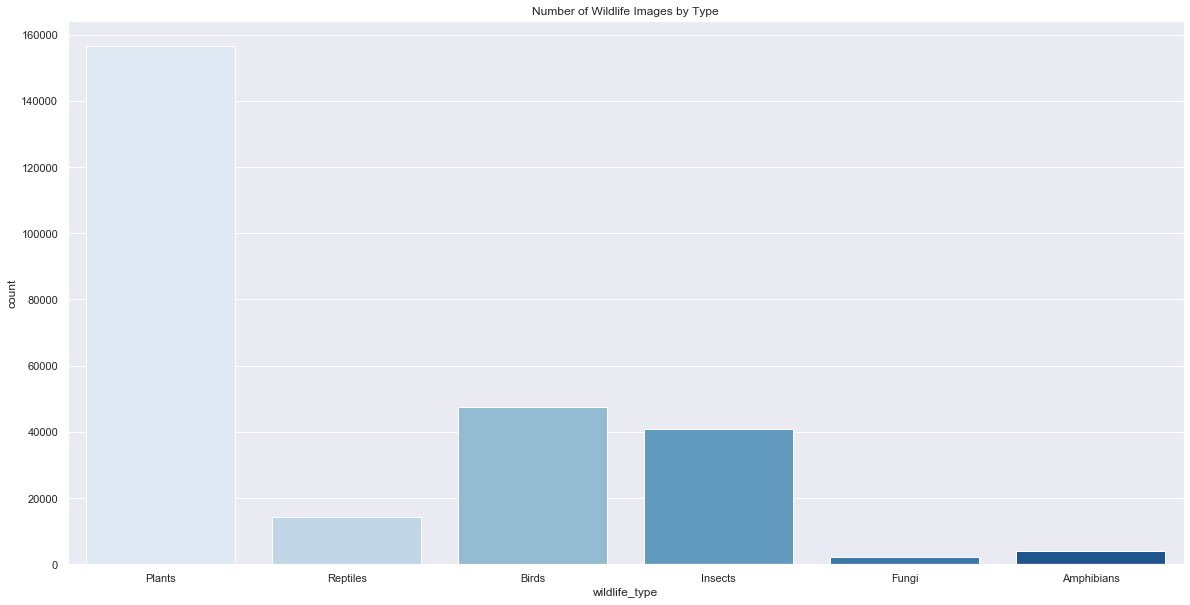

In [12]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.countplot('wildlife_type', data=df, palette='Blues')
_ = plt.title('Number of Wildlife Images by Type')

In [13]:
# get each type of animal type and the number of unique species included within. 
df.groupby(['wildlife_type'])[['species_id']].nunique()

,species_id
wildlife_type,
Amphibians,10
Birds,126
Fungi,12
Insects,141
Plants,682
Reptiles,39


As expected since it has the largest number of images, the Plants wildlife type also has the largest number of different species. 

#### Pixel Height and Width

Each image has a maximum height and width of 800 pixels, with more than 10,000 The average height is approximately 663 pixels, while the average width is 720. Images in the dataset tend to be wider (horizontal) than they are taller (vertical). 

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,265213.0,663.397748,121.240499,130.0,572.0,600.0,800.0,800.0
width,265213.0,720.810303,111.953950,188.0,600.0,800.0,800.0,800.0


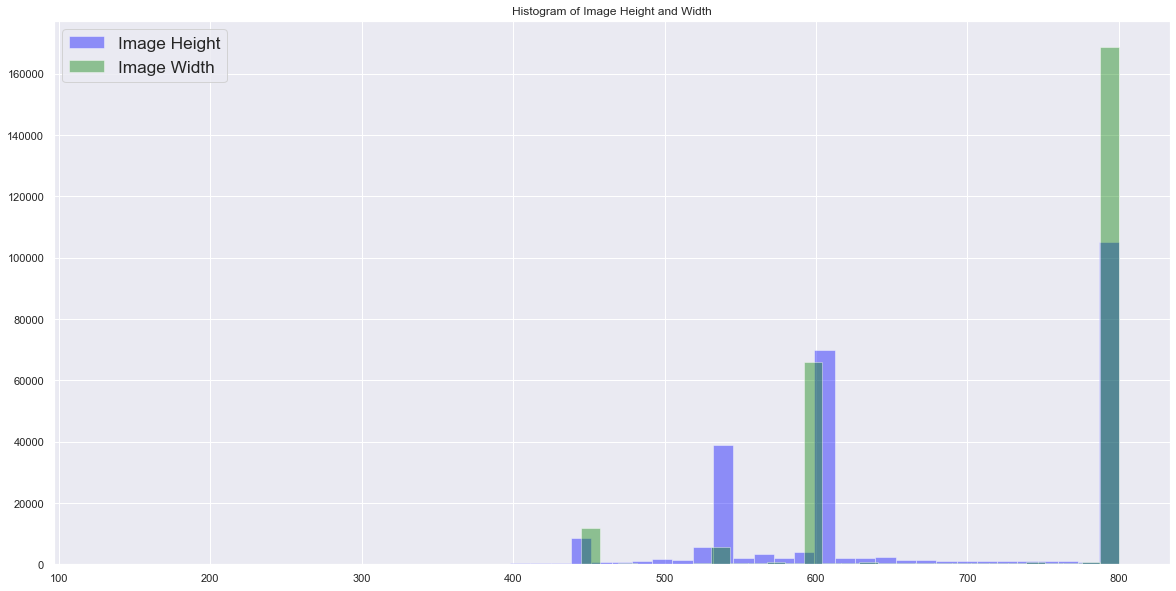

In [15]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sns.distplot( df["height"] , color="blue", label="Image Height", kde=False)
sns.distplot( df["width"] , color="green", label="Image Width", kde=False)
_ = plt.xlabel('')
_ = plt.title('Histogram of Image Height and Width')
_ = plt.legend(fontsize='x-large')

### VIEW SAMPLE IMAGES

Let's look at some sample images of each of the six types of wildlife. 

In [16]:
types = df['wildlife_type'].unique()

Plants


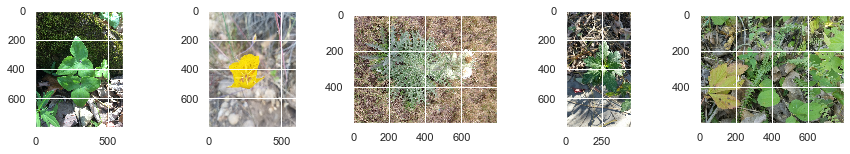

Reptiles


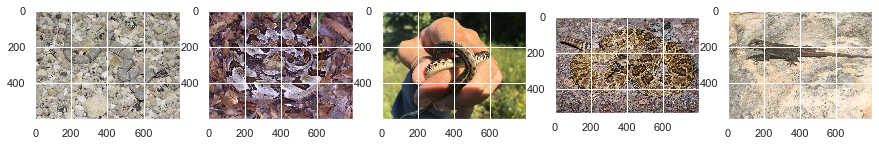

Birds


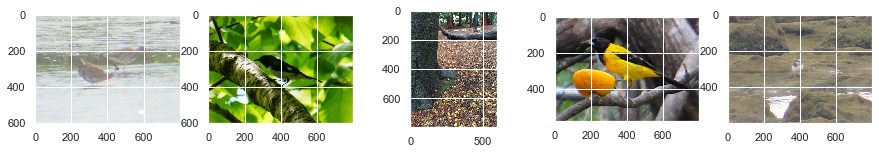

Insects


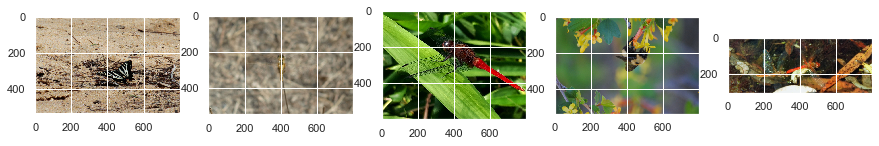

Fungi


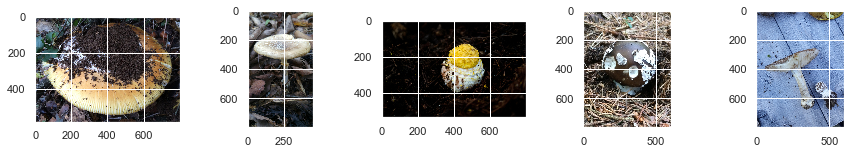

Amphibians


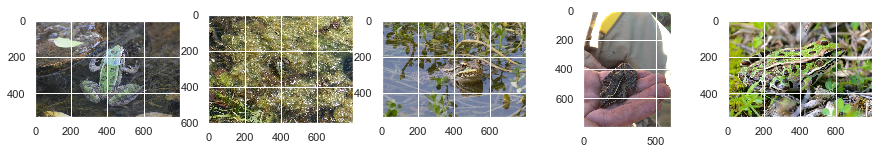

In [17]:
for type in types: 
    print(type)
    img_names = df[df['wildlife_type']== type ]['file_name'][300:305]
    plt.figure(figsize=[15,15])
    i = 1
    for img_name in img_names:
        img = cv2.imread("../data/raw/%s" % img_name)[...,[2, 1, 0]]
        plt.subplot(6, 5, i)
        plt.imshow(img)
        i += 1
    plt.show()

Many of the images are obscured in some way by other things since they are in their natural habitats. For instance, the amphibians are in water or are partly camoflauged in plants (another one of our categories). Being able to train a model that can distinguish between the two may be especially useful.

### PREPROCESSING & EXPORT

Finally, we'll use one-hot encoding to change categorical columns to binary values, and will export our file to csv for use later. 

In [18]:
# one hot encoding on all categorical variables
df = pd.get_dummies(df, prefix=['wildlife_type'], columns=['wildlife_type'])
df.head()

,file_name,height,width,species_id,wildlife_type_Amphibians,wildlife_type_Birds,wildlife_type_Fungi,wildlife_type_Insects,wildlife_type_Plants,wildlife_type_Reptiles
image_id,,,,,,,,,,
0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,800,600,400,0,0,0,0,1,0
1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,533,800,570,0,0,0,0,1,0
2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,600,800,167,0,0,0,0,0,1
3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,533,800,254,0,1,0,0,0,0
4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,600,800,739,0,0,0,0,1,0


In [19]:
# save to csv
df.to_csv('../data/interim/wildlife_interim.csv',index=False)

----

In [20]:
%load_ext watermark
%watermark -a "Lab 2.0" -d -t -v -p numpy,pandas

Lab 2.0 2020-09-07 16:55:27 

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
